//Copyright (c) Microsoft Corporation. All rights reserved. 
//Licensed under the MIT License.

In [1]:
import numpy as np 
import pandas as pd 
import sklearn 
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import warnings
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets import mnist,cifar10
import matplotlib.pyplot as plt
import sys
import pickle
from tqdm import tqdm
from keras import initializers
import matplotlib.pyplot as plt
import PrivacyGAN as pg 
from keras import backend as K
warnings.filterwarnings("ignore")

Using TensorFlow backend.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Load dataset

In [2]:
# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_all = np.concatenate((X_train,X_test))

(n, d1, d2, d3) = X_all.shape

if d3 !=3:
    X_all = np.moveaxis(X_all, 1, 3)
    
X_all = np.float32(X_all)
X_all = (X_all / 255 - 0.5) * 2
X_all = np.clip(X_all, -1, 1)

#Generate training test split
frac = 0.1 
n = int(frac*len(X_all))
l = np.array(range(len(X_all)))
l = np.random.choice(l,len(l),replace = False)
X = X_all[l[:n]]
X_comp = X_all[l[n:]]

print(X.shape)
print(X_comp.shape)

(6000, 32, 32, 3)
(54000, 32, 32, 3)


### Run simple GAN 

In [3]:
#Specify models 
generator = pg.CIFAR_Generator()
discriminator = pg.CIFAR_Discriminator()
generators = [pg.CIFAR_Generator(),pg.CIFAR_Generator()]
discriminators = [pg.CIFAR_Discriminator(),pg.CIFAR_Discriminator()]
pDisc = pg.CIFAR_DiscriminatorPrivate(OutSize = 2)

In [4]:
(generator, discriminator, dLosses, gLosses) = pg.SimpGAN(X, epochs = 500, 
                                                          generator = generator, 
                                                          discriminator = discriminator,
                                                          batchSize=256)

Epochs: 500
Batch size: 256
Batches per epoch: 23.4375
epoch = 1/500, d_loss=0.559, g_loss=0.777                                                                                                                    
epoch = 2/500, d_loss=0.323, g_loss=2.569                                                                                                                    
epoch = 3/500, d_loss=0.468, g_loss=2.812                                                                                                                    
epoch = 4/500, d_loss=0.400, g_loss=5.206                                                                                                                     
epoch = 5/500, d_loss=0.336, g_loss=4.096                                                                                                                     
epoch = 6/500, d_loss=0.269, g_loss=3.849                                                                                                                

In [5]:
#perform white box attack
Acc = pg.WBattack(X,X_comp, discriminator)

White-box attack accuracy: 0.7811666666666667


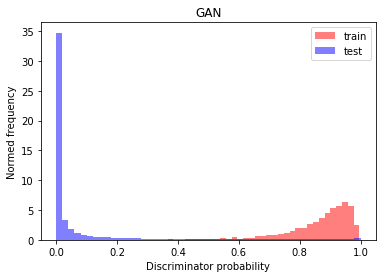

In [6]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminator.predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', normed = 1, bins = 50)
plt.hist(discriminator.predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', normed = 1, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('GAN')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

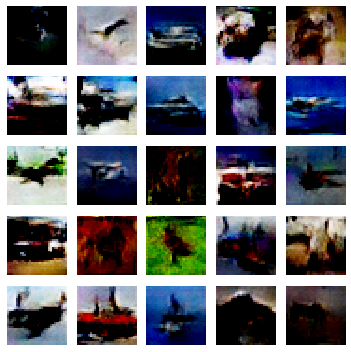

In [7]:
noise = np.random.normal(0, 1, size=[X.shape[0], 100])
generatedImages = generator.predict(noise)
temp = generatedImages[:25].reshape(25, 32, 32, 3)
plt.figure(figsize=(5, 5))
for i in range(temp.shape[0]):
    plt.subplot(5,5, i+1)
    plt.imshow(temp[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()

### Run Private GAN 

In [ ]:
K.clear_session()
optim = Adam(lr=0.0002, beta_1=0.5)
generator = pg.CIFAR_Generator(optim = Adam(lr=0.0002, beta_1=0.5))
discriminator = pg.CIFAR_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))
generators = [pg.CIFAR_Generator(optim = Adam(lr=0.0002, beta_1=0.5)),
              pg.CIFAR_Generator(optim = Adam(lr=0.0002, beta_1=0.5))]
discriminators = [pg.CIFAR_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5)),
                  pg.CIFAR_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))]
pDisc = pg.CIFAR_DiscriminatorPrivate(OutSize = 2,
                                     optim = Adam(lr=0.0002, beta_1=0.5))
(generators, discriminators, _, dLosses, dpLosses, gLosses)= pg.privGAN(X, epochs = 500,
                                                                           disc_epochs=50,
                                                                           generators = generators, 
                                                                           discriminators = discriminators,
                                                                           pDisc = pDisc,
                                                                           optim = optim,
                                                                           privacy_ratio=1.0,
                                                                           batchSize=256)

Train on 6000 samples, validate on 6000 samples
Epoch 1/50
6000/6000 [==============================] - 1s 185us/step - loss: 0.6938 - val_loss: 0.6908
Epoch 2/50
6000/6000 [==============================] - 0s 56us/step - loss: 0.6916 - val_loss: 0.6861
Epoch 3/50
6000/6000 [==============================] - 0s 55us/step - loss: 0.6872 - val_loss: 0.6753
Epoch 4/50
6000/6000 [==============================] - 0s 55us/step - loss: 0.6756 - val_loss: 0.6538
Epoch 5/50
6000/6000 [==============================] - 0s 56us/step - loss: 0.6563 - val_loss: 0.6222
Epoch 6/50
6000/6000 [==============================] - 0s 56us/step - loss: 0.6252 - val_loss: 0.5804
Epoch 7/50
6000/6000 [==============================] - 0s 56us/step - loss: 0.5893 - val_loss: 0.5342
Epoch 8/50
6000/6000 [==============================] - 0s 55us/step - loss: 0.5275 - val_loss: 0.4547
Epoch 9/50
6000/6000 [==============================] - 0s 56us/step - loss: 0.4711 - val_loss: 0.3811
Epoch 10/50
6000/6000 [=

In [8]:
#perform white box attack
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.4638333333333333
White-box attack accuracy (mean): 0.19733333333333333


(0.4638333333333333, 0.19733333333333333)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

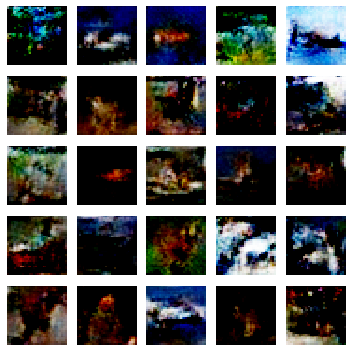

In [10]:
noise = np.random.normal(0, 1, size=[X.shape[0], 100])
generatedImages = generators[0].predict(noise)
temp = generatedImages[:25].reshape(25, 32, 32, 3)
plt.figure(figsize=(5, 5))
for i in range(temp.shape[0]):
    plt.subplot(5,5, i+1)
    plt.imshow(temp[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()

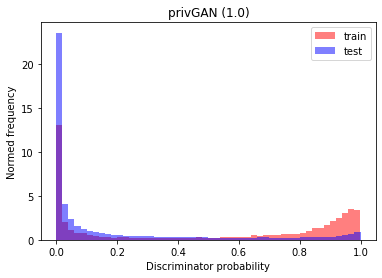

In [9]:
plt.hist(discriminators[0].predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', normed = 1, bins = 50)
plt.hist(discriminators[0].predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', normed = 1, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN (1.0)')
plt.legend()

In [8]:
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.15483333333333332
White-box attack accuracy (mean): 0.18366666666666667


(0.15483333333333332, 0.18366666666666667)